In [45]:
import sys
sys.path.append('..')

from utils import *
from data_utils import *
from metrics import *
from plots import *

In [46]:
from sklearn.metrics import classification_report

def eval(model, device, dataset_loader, debug):
    model.eval()
    test_loss, correct = 0., 0.
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in dataset_loader:
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(
                dim=1,
                keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data
    if debug:
        print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, num_data, 100. * acc))

    print(classification_report(all_labels, all_preds, target_names=[f'Class {i}' for i in range(len(set(all_labels)))]))

    return acc


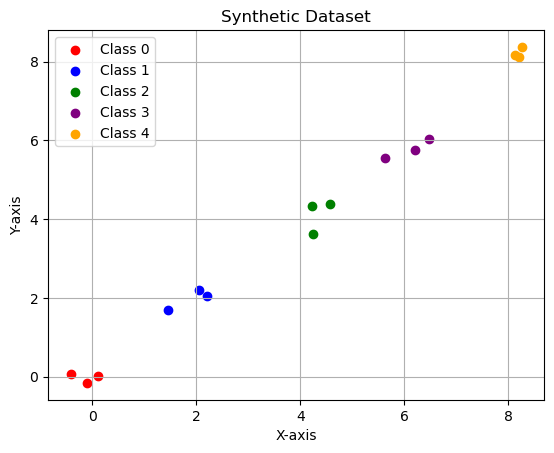

In [47]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data(n_classes, n_points, base_covariance, shift):
    """
    Generate synthetic data.
    
    Parameters:
        n_classes (int): The number of classes.
        n_points (int): The number of points per class.
        base_covariance (list of list of float): The base covariance matrix for generating points.
        shift (float): The shift in the mean for each subsequent class.
        
    Returns:
        X (np.ndarray): The feature array.
        y (np.ndarray): The label array.
    """
    
    X_list = []
    y_list = []
    
    for i in range(n_classes):
        # Mean for class i (shifted along the line y=x)
        mean = [i * shift, i * shift]
        
        # Generate points for class i
        x, y = np.random.multivariate_normal(mean, base_covariance, n_points).T
        
        # Labels for the points
        labels = np.full(n_points, i, dtype=int)
        
        X_list.append(np.column_stack((x, y)))
        y_list.append(labels)
        
    # Combine the points and labels
    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    
    # Shuffle the dataset
    shuffle_indices = np.random.permutation(n_classes * n_points)
    X = X[shuffle_indices]
    y = y[shuffle_indices]
    
    return X, y

# Seed for reproducibility
np.random.seed(42)

# Number of classes
n_classes = 5

# Number of points per class
n_points = 3

# Base covariance matrix for generating points
base_covariance = [[0.1, 0.05], [0.05, 0.1]]

# Shift in mean for each subsequent class
shift = 2.0

# Generate the data
X, y = generate_data(n_classes, n_points, base_covariance, shift)

# Plot the dataset
colors = ['red', 'blue', 'green', 'purple', 'orange']
for i in range(n_classes):
    plt.scatter(X[y==i][:, 0], X[y==i][:, 1], color=colors[i % len(colors)], label=f'Class {i}')

plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Synthetic Dataset')
plt.grid(True)
plt.show()


In [48]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [49]:
device = 'cpu'

depth = 10

params = dict(device=device,
                width=50, lr=0.001, num_train=50,
                sb=0.05, depth= depth, sw=1.7346938775510203, early_stop_patience = 5, activation_function='tanh')

# Generate the synthetic dataset
n_classes = 5
n_points = 100
base_covariance = [[0.1, 0.05], [0.05, 0.1]]
shift = 2.0
X, y = generate_data(n_classes, n_points, base_covariance, shift)

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Create DNN model
input_dim = 2  # 2D data points
output_dim = n_classes  # Number of classes
model = generate_fc_dnn(input_dim, output_dim, params)
#model = generate_fc_dnn_relu(input_dim, output_dim, params)


# Create a 'Namespace' to supply to the training function (to comply with your function's requirements)
from types import SimpleNamespace
dataset_namespace = SimpleNamespace(train_loader=train_loader, test_loader=test_loader, val_loader=test_loader)

# Train and evaluate
train_acc, test_acc, model, _ = compute_training_acc_epochs(model, dataset_namespace, params, debug=True)

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")

Epoch: 0 	Training Accuracy: 10.40%
Validation Accuracy: 10.40%
Epoch: 1 	Training Accuracy: 56.60%
Validation Accuracy: 56.60%
Epoch: 2 	Training Accuracy: 60.00%
Validation Accuracy: 60.00%
Epoch: 3 	Training Accuracy: 75.40%
Validation Accuracy: 75.40%
Epoch: 4 	Training Accuracy: 89.40%
Validation Accuracy: 89.40%
Epoch: 5 	Training Accuracy: 80.00%
Validation Accuracy: 80.00%
val_acc: 0.8, max_val_acc: 0.894, no_improve_epochs: 1
Epoch: 6 	Training Accuracy: 77.60%
Validation Accuracy: 77.60%
val_acc: 0.776, max_val_acc: 0.894, no_improve_epochs: 2
Epoch: 7 	Training Accuracy: 99.00%
Validation Accuracy: 99.00%
Epoch: 8 	Training Accuracy: 98.80%
Validation Accuracy: 98.80%
val_acc: 0.988, max_val_acc: 0.99, no_improve_epochs: 1
Epoch: 9 	Training Accuracy: 96.60%
Validation Accuracy: 96.60%
val_acc: 0.966, max_val_acc: 0.99, no_improve_epochs: 2
Epoch: 10 	Training Accuracy: 99.40%
Validation Accuracy: 99.40%
Epoch: 11 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
Epoc

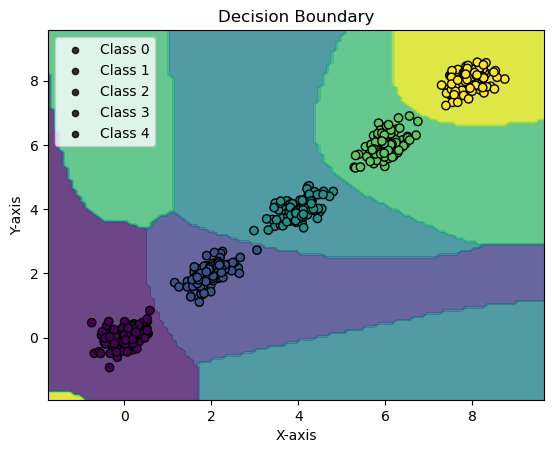

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_decision_boundary(model, X, y, n_classes):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    with torch.no_grad():
        model.eval()
        Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).numpy()
        Z = np.argmax(Z, axis=1)

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', linewidth=1)
    plt.title("Decision Boundary")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")

    for i in range(n_classes):
        plt.scatter([], [], c='k', alpha=0.8, s=20, label=f"Class {i}")
    plt.legend(loc='upper left')

    plt.show()

# After training
plot_decision_boundary(model, X, y, n_classes)


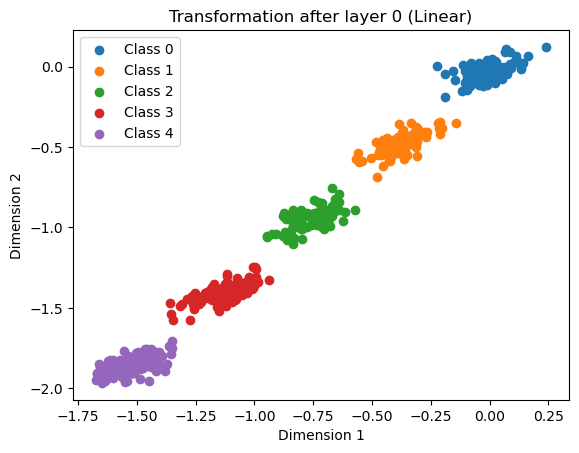

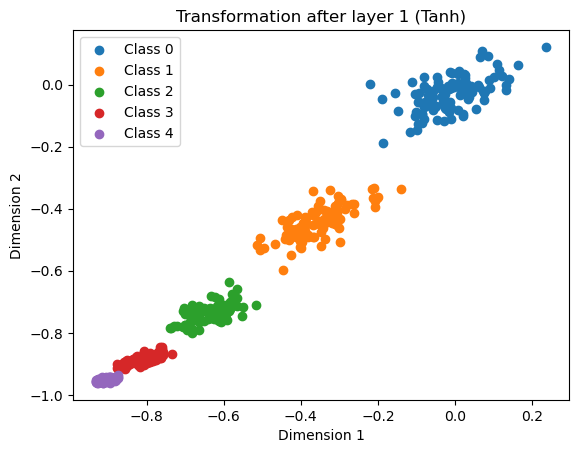

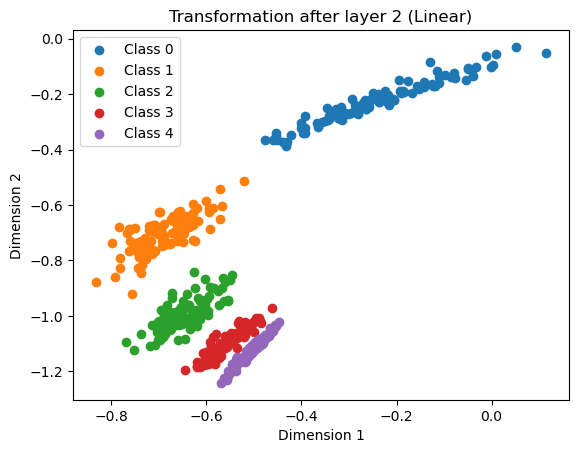

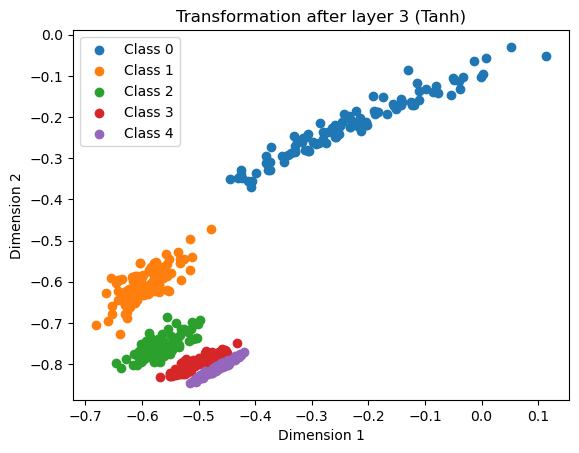

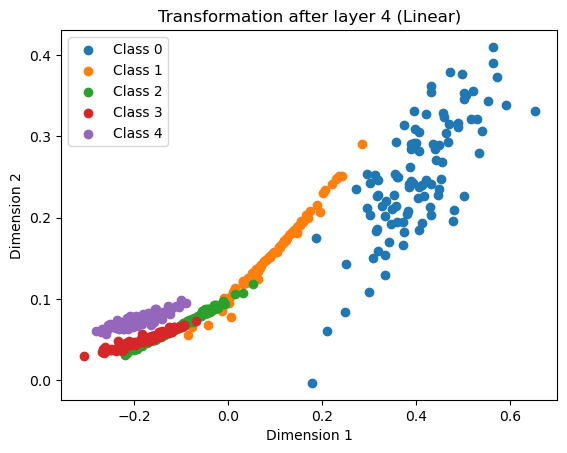

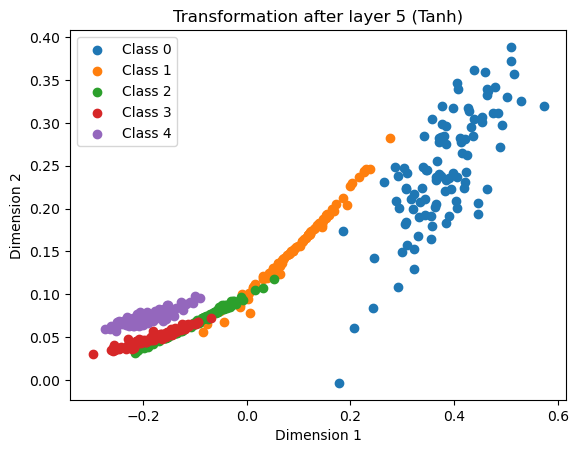

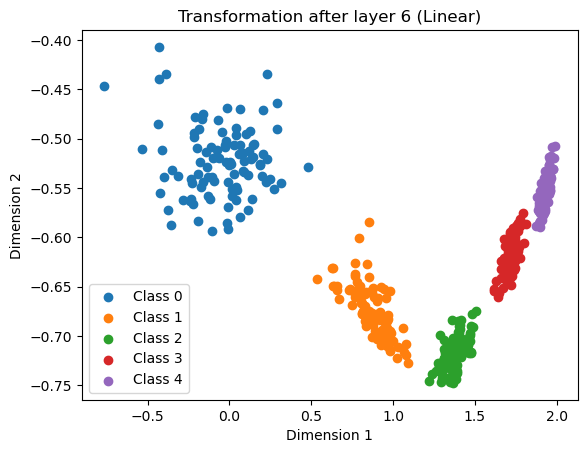

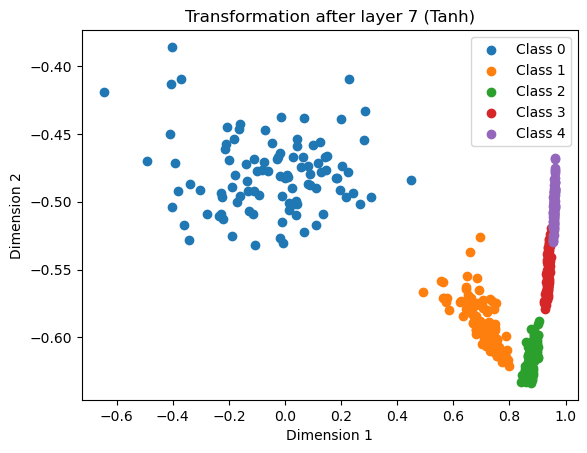

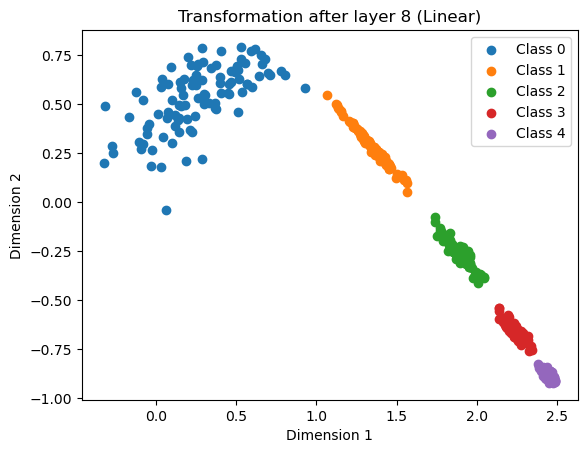

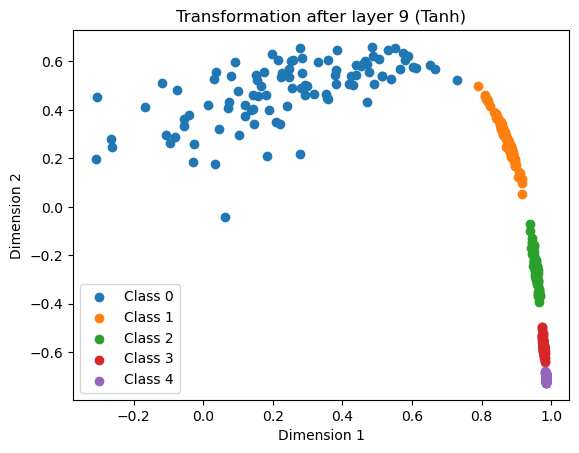

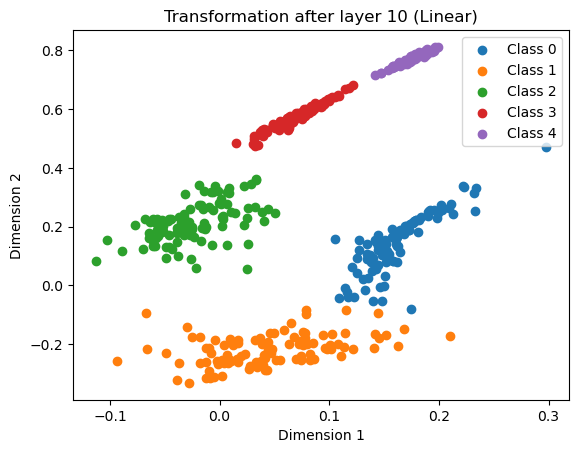

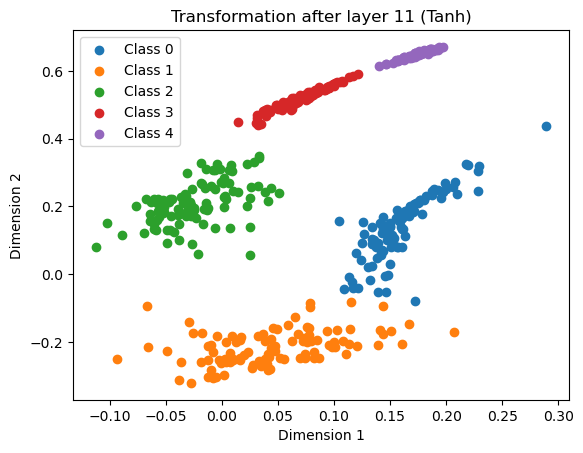

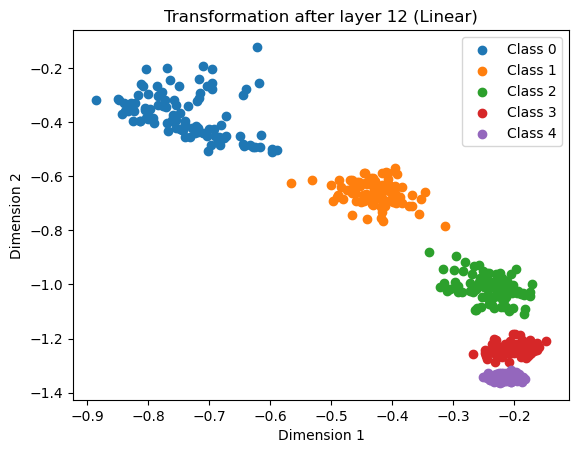

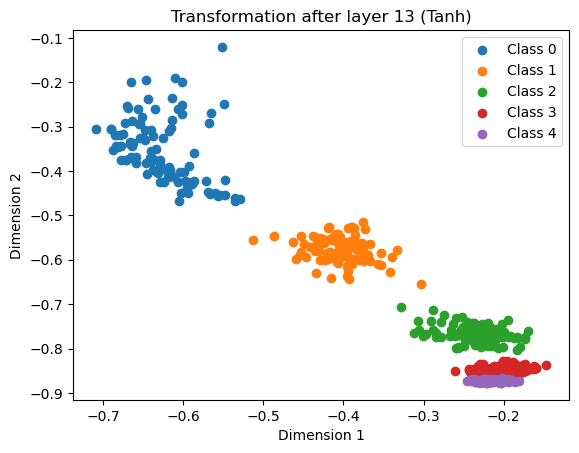

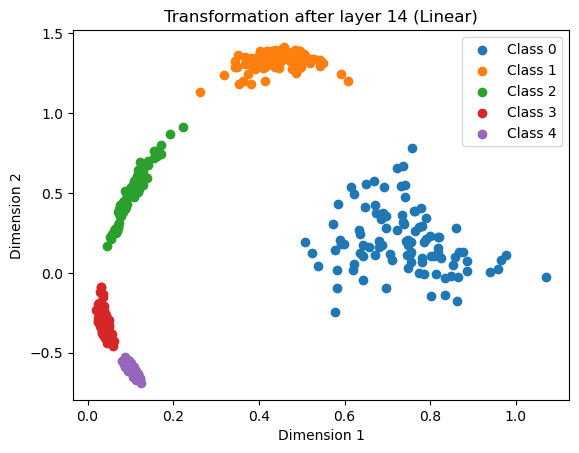

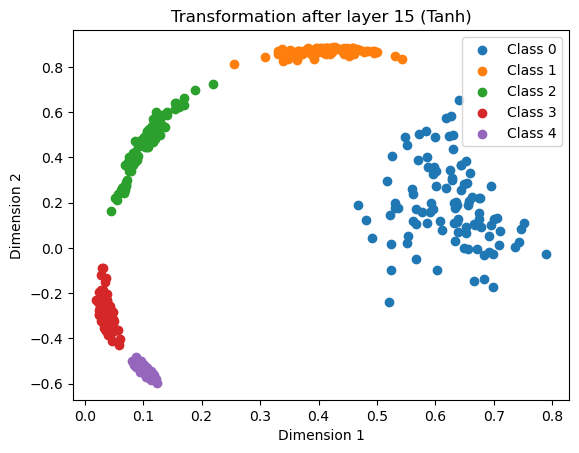

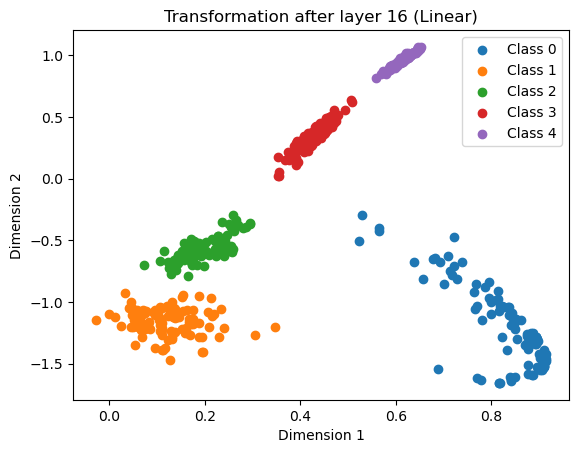

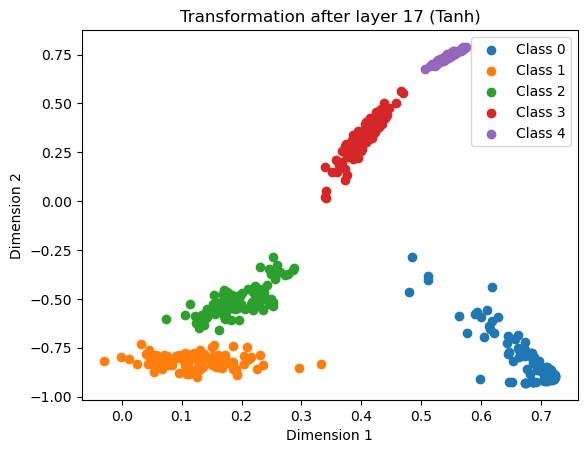

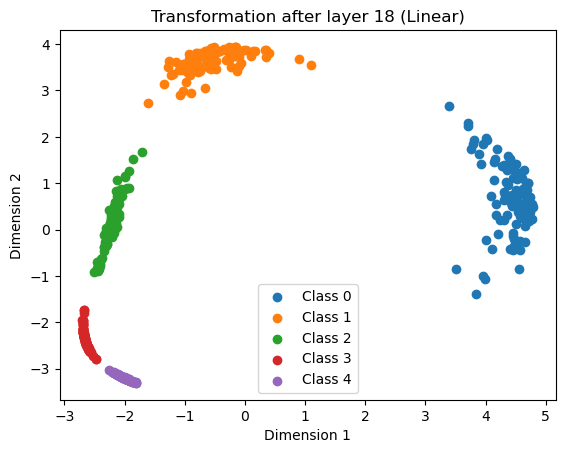

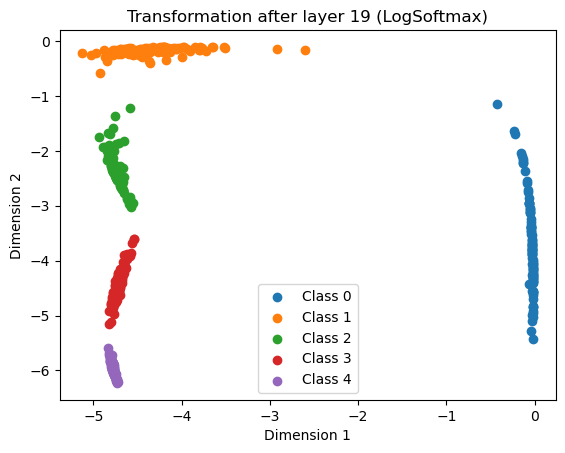

In [51]:
import matplotlib.pyplot as plt

def plot_layer_transformations(model, X, y, layer_indices):
    n_classes = len(np.unique(y))
    X_transformed = torch.FloatTensor(X)
    
    for i, layer_index in enumerate(layer_indices):
        layer = model[layer_index]
        
        with torch.no_grad():
            X_transformed = layer(X_transformed)
            
        if isinstance(layer, nn.Linear) or isinstance(layer, nn.Tanh) or isinstance(layer, nn.LogSoftmax):
            X_transformed_numpy = X_transformed.detach().cpu().numpy()
            
            plt.figure()
            for class_idx in range(n_classes):
                idxs = np.where(y == class_idx)[0]
                plt.scatter(X_transformed_numpy[idxs, 0], X_transformed_numpy[idxs, 1], label=f"Class {class_idx}")
            
            layer_type = type(layer).__name__
            plt.title(f'Transformation after layer {layer_index} ({layer_type})')
            plt.xlabel('Dimension 1')
            plt.ylabel('Dimension 2')
            plt.legend()

# Indicate which layers you are interested in (by index).
layer_indices = list(range(depth*2))

# X should be your original data and y should be the labels.
plot_layer_transformations(model, X, y, layer_indices)

plt.show()


In [52]:
eval(model, device, test_loader, debug=True)


Train set: Average loss: 0.2897, Accuracy: 500.0/500 (100%)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       100
     Class 1       1.00      1.00      1.00       100
     Class 2       1.00      1.00      1.00       100
     Class 3       1.00      1.00      1.00       100
     Class 4       1.00      1.00      1.00       100

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



1.0

In [56]:
#save model
torch.save(model, f"model_{depth}_synthetic_data_against_overfitting.pt")

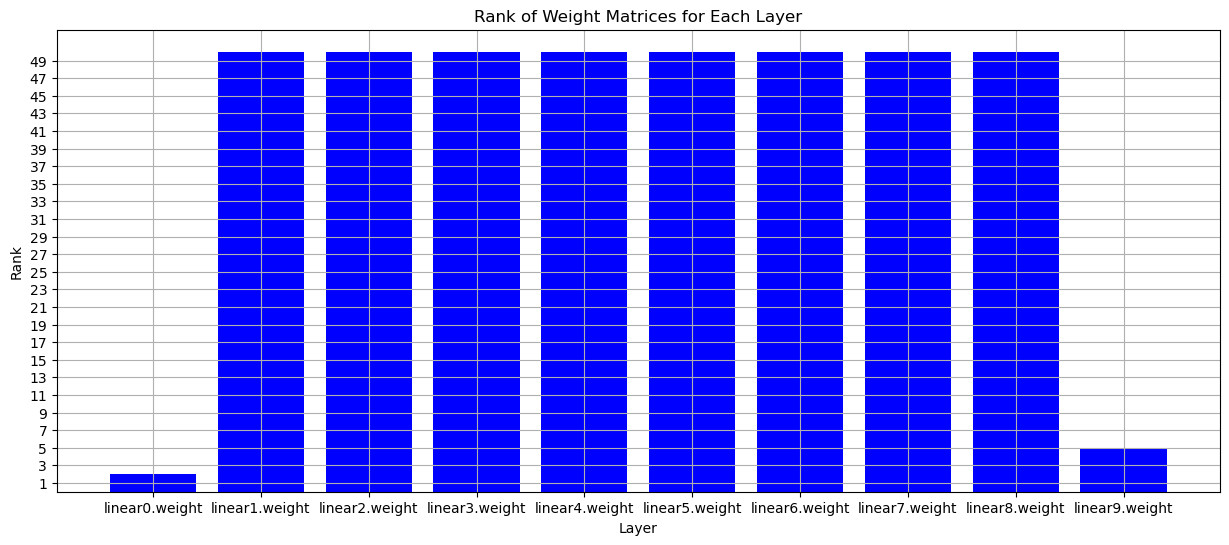

In [53]:
import numpy as np
import matplotlib.pyplot as plt

def plot_layer_ranks(model):
    ranks = []
    layer_names = []
    
    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            rank = np.linalg.matrix_rank(weight_matrix)
            ranks.append(rank)
            layer_names.append(name)
    
    # Plotting
    plt.figure(figsize=(15, 6))
    plt.bar(layer_names, ranks, color='blue')
    plt.xlabel('Layer')
    plt.ylabel('Rank')
    plt.title('Rank of Weight Matrices for Each Layer')
    plt.grid(True)
    
    y_max = np.max(ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(y_min, y_max, step=2))  # Set yticks

    plt.show()

# Example usage
plot_layer_ranks(model)  # Note: You'll need to define or load 'model' before calling this function


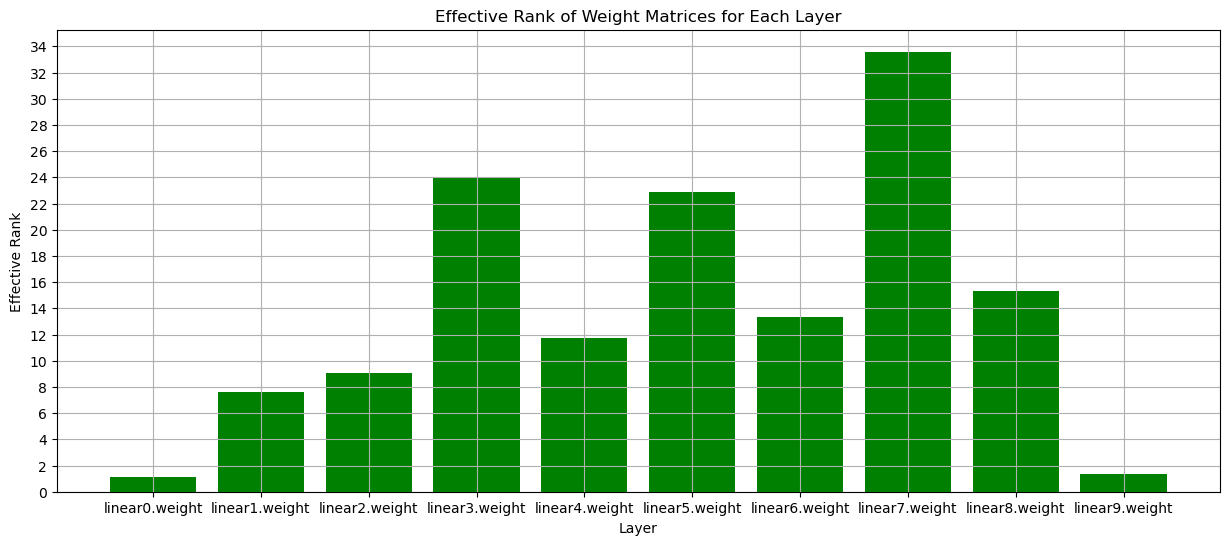

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def effective_rank(singular_values):
    sigma_max = np.max(singular_values)
    sigma_min = singular_values[-1] if singular_values[-1] > 0 else np.min(singular_values[singular_values > 0])
    # print(sigma_max, sigma_min)
    # print(np.sqrt(sigma_max / sigma_min))
    # print('----')
    return np.sqrt(sigma_max / sigma_min)

def plot_layer_effective_ranks(model):
    effective_ranks = []
    layer_names = []
    
    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            singular_values = np.linalg.svd(weight_matrix, compute_uv=False)
            eff_rank = effective_rank(singular_values)
            effective_ranks.append(eff_rank)
            layer_names.append(name)
    
    # Plotting
    plt.figure(figsize=(15, 6))
    plt.bar(layer_names, effective_ranks, color='green')
    plt.xlabel('Layer')
    plt.ylabel('Effective Rank')
    plt.title('Effective Rank of Weight Matrices for Each Layer')
    plt.grid(True)
    
    y_max = np.max(effective_ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(effective_ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(0, int(y_max)+2, step=2))  # Set yticks

    plt.show()

# Example usage
plot_layer_effective_ranks(model)  # Note: You'll need to define or load 'model' before calling this function


/Users/davidguzman/Documents/GitHub/mp-tl-study/David/../plots.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(conv_layer_names, rotation=90)
/Users/davidguzman/Documents/GitHub/mp-tl-study/David/../plots.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(activation_layer_names, rotation=90)


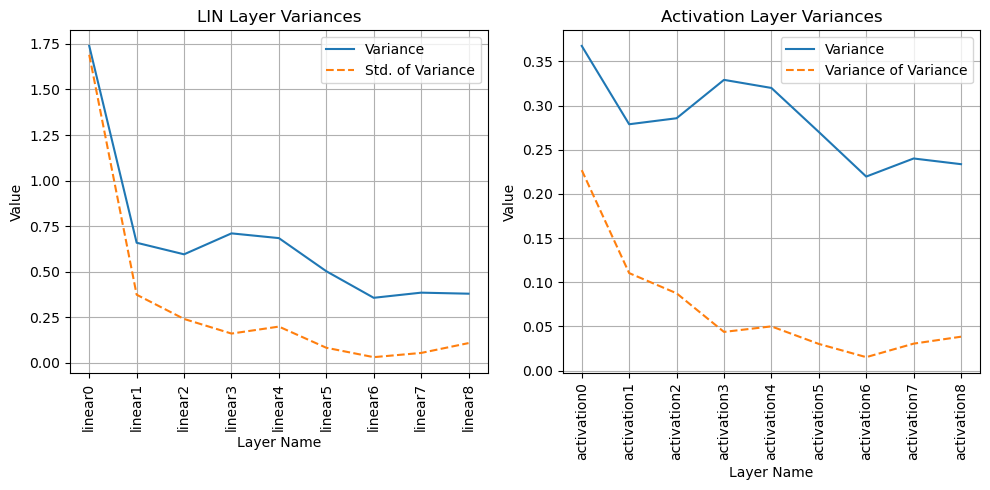

In [55]:
results, variances = compute_layer_variances_dense(model, test_loader, device = 'cpu',cnn=False)
plot_variances_by_layer_type(variances, results, cnn = False, ignore_final_layer=True, std_of_variance = True )